In [3]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import *

from pyfrechet.metric_spaces import wasserstein_1d as ws
from scipy import stats 

from pyfrechet.metric_spaces import MetricData, Wasserstein1D

from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree

INFO: Using numpy backend


In [69]:
GRID = np.linspace(0, 1, 100)
STD_NORMAL_Q = stats.norm.ppf(GRID)
N = 20
d = 1

    
def sample_linear_transport(x, sig=1, gam=0.5):
    gam = np.random.gamma(1, 1)
    sig = np.random.exponential(1)
    Q0 = gam - np.log(1 + np.sum(x)) + (sig + np.sum(x**2)) * STD_NORMAL_Q
    return (Q0 + 20) / 40  # scale to [0, 1]

def gen_data(N, J=5, d=1):
    compose = lambda f, g: np.interp(g, GRID, f)
    x = np.random.uniform(0, 1, N * d).reshape((N, d))
    y = np.array([ compose(ws.noise(J), sample_linear_transport(x[i,:])) for i in range(N)])
    return x, y

N = 20; J=20; d=10
x_train, y_train= gen_data(N,J,d)
x_test, y_test = gen_data(N,J,d)

In [71]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 
sys.path.append(os.getcwd())
import pickle 
import numpy as np

from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
 # Set the correct path to the pyfrechet module
#sys.path.insert(1, 'C:/Users/Diego/Desktop/Doctorado/codi/pballs')
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree
from pyfrechet.metric_spaces import MetricData, Wasserstein1D
from pyfrechet.metric_spaces import wasserstein_1d as ws
from scipy import stats 

# By-blocks execution
n_samples=len(os.listdir(os.path.join(os.getcwd(), 'wass_data/')))
n_cores=56
#n_cores=int(input('Introduce number of cores: '))
n_blocks = n_samples/n_cores
current_block = 3

file = 'WASS_Samp100.pkl'
# Data from the selected file
sign_level = np.array([0.01, 0.05, 0.1])
with open(os.path.join(os.getcwd(),  'wass_data/' + file), 'rb') as f:
    print(f)
    print(file)
    sample = pickle.load(f)
    print(sample)

X=np.c_[sample['x']]
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)
print(X)
y = np.array(sample['y'])
print(y)
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=None, # It is a regression curve setting, only one predictor
            min_split_size=1)

forest = BaggedRegressor(estimator=base,
                            n_estimators = 50,
                            bootstrap_fraction=1,
                            bootstrap_replace=True,
                            n_jobs=1)


M = Wasserstein1D()
y = MetricData(M, y)

forest.fit(X, y)

oob_errors = forest.oob_errors()

Dalpha = np.percentile(oob_errors, (1-sign_level)*100)

results = {'y_train_data': y.data,
            'train_predictions': forest.predict(X).data,
            'OOB_errors': oob_errors,
            'OOB_quantile' : Dalpha,
            'forest': forest,
            }

filename = file[:-4] + '_block_' + str(current_block) + '_results'
np.save(filename, results)

print(f'Block number: {current_block}')
# One sample by core in the current block

<_io.BufferedReader name='/Users/Diego/Desktop/Codigo/pballs/simulations_Wass/wass_data/WASS_Samp100.pkl'>
WASS_Samp100.pkl
{'x': array([[0.93894623, 0.93927476, 0.37316222, ..., 0.5806823 , 0.76698205,
        0.50566394],
       [0.2417912 , 0.56608793, 0.90248477, ..., 0.05498762, 0.66970197,
        0.80904728],
       [0.38166728, 0.19219797, 0.32172281, ..., 0.26589896, 0.45623939,
        0.72200015],
       ...,
       [0.39903828, 0.67030362, 0.90474977, ..., 0.59552518, 0.21310493,
        0.32550255],
       [0.31374508, 0.87991034, 0.72908904, ..., 0.32087003, 0.67018885,
        0.46992072],
       [0.17202477, 0.45305978, 0.83549096, ..., 0.81705889, 0.46325716,
        0.34544312]]), 'y': array([[       -inf, -0.0938345 , -0.03002728, ...,  0.92812918,
         0.99193639,         inf],
       [       -inf,  0.05937108,  0.1079496 , ...,  0.83742555,
         0.88600408,         inf],
       [       -inf,  0.00151377,  0.05478979, ...,  0.85480523,
         0.90808125,  

ValueError: y contains NaNs or infinite values

In [489]:
M = Wasserstein1D()
y_train = MetricData(M, y_train)
sign_level = np.array([0.1, 0.05, 0.01])

base = Tree(split_type='2means',
                impurity_method='cart',
                mtry=None, #only one predictor
                min_split_size=1)
    
forest = BaggedRegressor(estimator=base,
                                n_estimators=100,
                                bootstrap_fraction=1,
                                bootstrap_replace=True,
                                n_jobs=1)

forest.fit(x_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(min_split_size=1, split_type='2means'),
                n_jobs=1)

In [490]:
oob_errors = forest.oob_errors()

Dalpha = np.percentile(oob_errors, (1-sign_level)*100)

results = {'y_train_data': y_train.data,
            'train_predictions': forest.predict(x_train).data,
            'OOB_errors': oob_errors,
            'OOB_quantile' : Dalpha,
            'forest': forest,
            }

{'whiskers': [<matplotlib.lines.Line2D at 0x1286ef640>,
 'caps': [<matplotlib.lines.Line2D at 0x1286efb80>,
 'boxes': [<matplotlib.lines.Line2D at 0x1286ef3a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1286fc100>],
 'fliers': [<matplotlib.lines.Line2D at 0x1286fc3a0>],
 'means': []}

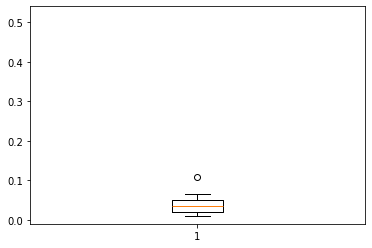

In [491]:
%matplotlib inline
preds = results['train_predictions'].data
theo_errs = np.zeros((2, x_test.shape[0]))
errs = np.zeros((2, x_test.shape[0]))
theo_errs = results['OOB_errors']

plt.subplot()
plt.ylim(-0.01, 0.54)

plt.boxplot(theo_errs)

In [144]:
print(theo_errs)

[0.02074636 0.06268509 0.04843061 0.05926908 0.07285765 0.03174216
 0.08592783 0.13081258 0.04535067 0.0119778  0.03001102 0.02130505
 0.07519447 0.19630553 0.17038149 0.02508076 0.05255649 0.14535916
 0.04299567 0.05360615]


In [27]:
frachet_mean = ws.frachet_mean(y_train, np.ones(N)/N)
fvar = np.sum([ ws.d(frachet_mean, y_test[i,:])**2 for i in range(N) ])

# N=200; s=150; J=20; d=3
# (0.8607352116938509, 0.8603832277524206)


# N=200; s=150; J=20; d=10
# (0.8602941179000505, 0.6072508545516133)


1 - errs[0,:].sum() / fvar, 1 - errs[1,:].sum() / fvar

(0.8602941179000505, 0.6072508545516133)